Сначала идет подготовка данных так что можноэти ячейки не выполнять- они уже выполнены. Сам код ниже после условия лабы

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as sci_opt
from math import sqrt, exp, pi
from scipy.stats import norm
from matplotlib.colors import ListedColormap

from PIL import Image, ImageDraw
from numpy import *
from pylab import *
import os
import pydot
from itertools import combinations
from scipy.cluster.vq import *

from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from scipy import stats

from numpy.random import randn
import pickle

import cv2
import os

from skimage.color import rgb2gray

from skimage.feature import (match_descriptors, corner_harris,
                             corner_peaks, ORB, plot_matches)
from skimage import io

In [5]:
def pca(X):
    """ Анализ главных компонентов
     ввод: X, матрица с обучающими данными, хранящимися в виде сглаженных массивов в строках
     возврат: матрица проекции (сначала важные измерения), дисперсия и среднее значение.
     """
    # get dimensions
    num_data,dim = X.shape
    # center data
    mean_X = X.mean(axis=0)
    X = X - mean_X
    if dim>num_data:
        # PCA - compact trick used
        M = dot(X,X.T) # covariance matrix
        e,EV = linalg.eigh(M) # eigenvalues and eigenvectors
        tmp = dot(X.T,EV).T # this is the compact trick
        V = tmp[::-1] # reverse since last eigenvectors are the ones we want
        S = sqrt(e)[::-1] # reverse since eigenvalues are in increasing order

        for i in range(V.shape[1]):
            V[:,i] /= S
    else:
        # PCA - SVD used
        U,S,V = linalg.svd(X)
        V = V[:num_data] # only makes sense to return the first num_data
        # return the projection matrix, the variance and the mean
    return V,S,mean_X

class KnnClassifier(object):

    def __init__(self,labels,samples):
        """ Initialize classifier with training data. """

        self.labels = labels
        self.samples = samples

    def classify(self,point,k=3):
        """ Classify a point against k nearest
            in the training data, return label. """

        # compute distance to all training points
        dist = array([L2dist(point,s) for s in self.samples])

        # sort them
        ndx = dist.argsort()

        # use dictionary to store the k nearest
        votes = {}
        for i in range(k):
            label = self.labels[ndx[i]]
            votes.setdefault(label,0)
            votes[label] += 1

        return max(votes)


def L2dist(p1,p2):
    return sqrt( sum( (p1-p2)**2) )

def L1dist(v1,v2):
    return sum(abs(v1-v2))

def plot_2D_boundary(plot_range,points,decisionfcn,labels,values=[0]):
    """ Plot_range (xmin,xmax,ymin,ymax), точки - это список
         очков класса, решение fcn — это функция оценки,
         labels — это список меток, которые команда optionfcn возвращает для каждого класса.
         values — это список контуров решений для отображения. """

    clist = ['b','r','g','k','m','y'] # colors for the classes

    # evaluate on a grid and plot contour of decision function
    x = arange(plot_range[0],plot_range[1],.1)
    y = arange(plot_range[2],plot_range[3],.1)
    xx,yy = meshgrid(x,y)
    xxx,yyy = xx.flatten(),yy.flatten() # lists of x,y in grid
    zz = array(decisionfcn(xxx,yyy))
    zz = zz.reshape(xx.shape)
    # plot contour(s) at values
    contour(xx,yy,zz,values)

    # for each class, plot the points with '*' for correct, 'o' for incorrect
    for i in range(len(points)):
        d = decisionfcn(points[i][:,0],points[i][:,1])
        correct_ndx = labels[i]==d
        incorrect_ndx = labels[i]!=d
        plot(points[i][correct_ndx,0],points[i][correct_ndx,1],'*',color=clist[i])
        plot(points[i][incorrect_ndx,0],points[i][incorrect_ndx,1],'o',color=clist[i])

    axis('equal')

In [ ]:
def process_image_dsift(imagename,resultname,size=20,steps=10,force_orientation=False,resize=None):
    """ Process an image with densely sampled SIFT descriptors
        and save the results in a file. Optional input: size of features,
        steps between locations, forcing computation of descriptor orientation
        (False means all are oriented upwards), tuple for resizing the image."""

    im = Image.open(imagename).convert('L')
    if resize!=None:
        im = im.resize(resize)
    m,n = im.size

    if imagename[-3:] != 'pgm':
        #create a pgm file
        im.save('tmp.pgm')
        imagename = 'tmp.pgm'

    # create frames and save to temporary file
    scale = size/3.0
    x,y = meshgrid(range(steps,m,steps),range(steps,n,steps))
    xx,yy = x.flatten(),y.flatten()
    frame = array([xx,yy,scale*ones(xx.shape[0]),zeros(xx.shape[0])])
    savetxt('tmp.frame',frame.T,fmt='%03.3f')

    if force_orientation:
        cmmd = str("sift "+imagename+" --output="+resultname+
                    " --read-frames=tmp.frame --orientations")
    else:
        cmmd = str("sift "+imagename+" --output="+resultname+
                    " --read-frames=tmp.frame")
    os.system(cmmd)
    print('processed', imagename, 'to', resultname)

path = 'data/hand_gesture/test/'
imlist = []
for filename in os.listdir(path):
    if os.path.splitext(filename)[1] == '.ppm':
        imlist.append(path+filename)


# process images at fixed size (50,50)
for filename in imlist:
    featfile = filename[:-3]+'dsift'
    process_image_dsift(filename, featfile, 10, 5, resize=(50,50))

---

## Задание
1. Применить метод K-ближайших соседей к "сырым" исходным изображениям и сравнить результаты с тем, что получено при извлечении признаков и снижении разерности.
2. Применить к выделенным DSIFT признакам несколько различных классификаторов из библиотеки Scikit-Learn, опредилить наилучший результат классификации.

In [46]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from PIL import Image
import os
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


1. На сырых изобажениях

In [73]:
def load_images(folder_path):
    images = []
    labels = []
    labels_name = []
    label_map = {'A': 0, 'B': 1, 'C': 2, 'F': 3, 'P': 4, 'V': 5}  # Сопоставление буквенных меток с числовыми значениями
    for filename in os.listdir(folder_path):
        if filename.endswith(".ppm"):
            img_path = os.path.join(folder_path, filename)
            label_str = filename.split('-')[0][0]  # Получение буквенной метки из имени файла
            label_num = label_map[label_str]  # Получение числовой метки из словаря
            img = Image.open(img_path)
            img = img.resize((50,50))
            img_array = np.array(img).reshape(-1)  # Преобразование изображения в одномерный массив
            images.append(img_array)
            labels_name.append(label_str)  # Добавление буквенной метки
            labels.append(label_num)  # Добавление числовой метки
    return images, labels, labels_name

train_images, train_labels, train_labels_name = load_images("data/hand_gesture/train")
test_images, test_labels, train_labels_name = load_images("data/hand_gesture/test")

In [74]:
X_train = np.array(train_images)
y_train = np.array(train_labels)
X_test = np.array(test_images)
y_test = np.array(test_labels)

# Инициализация и обучение KNN
knn_classifier = KNeighborsClassifier(n_neighbors=3)
knn_classifier.fit(X_train, y_train)

# Предсказание на тестовых данных
y_pred = knn_classifier.predict(X_test)

# Оценка точности модели
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.44623655913978494


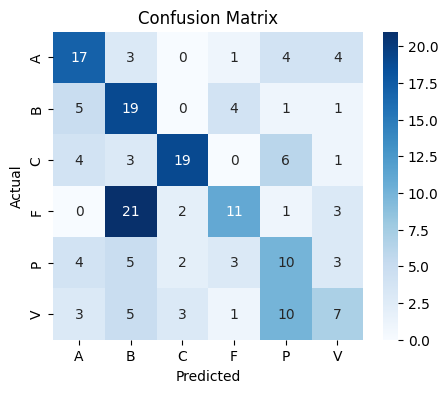

In [75]:
# Создание матрицы ошибок
conf_matrix = confusion_matrix(y_test, y_pred)

# Визуализация с помощью heatmap из библиотеки seaborn
label_map = {'A': 0, 'B': 1, 'C': 2, 'F': 3, 'P': 4, 'V': 5}
class_names = list(label_map.keys())

plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

2. Анализ по фичам из изображений

In [76]:
def read_features_from_file(filename):
    """ Чтение свойств объекта и возврат в матричной форме. """

    f = loadtxt(filename)
    return f[:,:4],f[:,4:] # feature locations, descriptors


def read_gesture_features_labels(path):
    # create list of all files ending in .dsift
    featlist = [os.path.join(path,f) for f in os.listdir(path) if f.endswith('.dsift')]

    # read the features
    features = []
    for featfile in featlist:
        l,d = read_features_from_file(featfile)
        features.append(d.flatten())
    features = array(features)

    # create labels
    labels_text = [featfile.split('\\')[-1][0] for featfile in featlist]
    label_map = {'A': 0, 'B': 1, 'C': 2, 'F': 3, 'P': 4, 'V': 5}
    labels = [label_map[featfile.split('\\')[-1][0]] for featfile in featlist]

    return np.array(features), np.array(labels), labels_text

train_path = 'data/hand_gesture/train'  # Путь к папке с обучающими данными .dsift
test_path = 'data/hand_gesture/test'    # Путь к папке с тестовыми данными .dsift

# Загрузка признаков и меток для обучающих данных
train_features, train_labels, labels_text_train = read_gesture_features_labels(train_path)

# Загрузка признаков и меток для тестовых данных
test_features, test_labels, labels_text_test = read_gesture_features_labels(test_path)


In [77]:
X_train = np.array(train_features)
y_train = np.array(train_labels)
X_test = np.array(test_features)
y_test = np.array(test_labels)

# Инициализация и обучение KNN
knn_classifier = KNeighborsClassifier(n_neighbors=3)
knn_classifier.fit(X_train, y_train)

# Предсказание на тестовых данных
y_pred = knn_classifier.predict(X_test)

# Оценка точности модели
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.8118279569892473


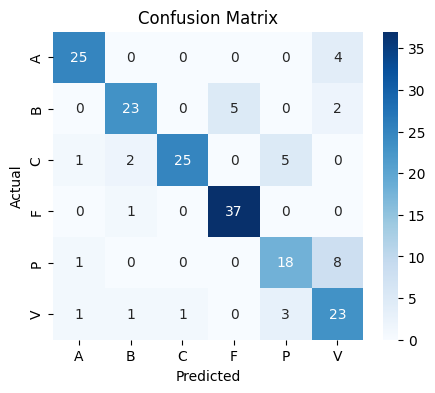

In [78]:
# Создание матрицы ошибок
conf_matrix = confusion_matrix(y_test, y_pred)

# Визуализация с помощью heatmap из библиотеки seaborn
label_map = {'A': 0, 'B': 1, 'C': 2, 'F': 3, 'P': 4, 'V': 5}
class_names = list(label_map.keys())

plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [88]:
from sklearn.decomposition import PCA

# Преобразование данных с использованием PCA
pca = PCA(n_components=0.95)  # Указываем, что хотим сохранить 95% объяснимой дисперсии
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Инициализация и обучение KNN на данных после применения PCA
knn_classifier = KNeighborsClassifier(n_neighbors=3)
knn_classifier.fit(X_train_pca, y_train)

# Предсказание на тестовых данных
y_pred_pca = knn_classifier.predict(X_test_pca)

# Оценка точности модели после PCA
accuracy_pca = accuracy_score(y_test, y_pred_pca)
print(f"Accuracy after PCA: {accuracy_pca}")


Accuracy after PCA: 0.8172043010752689


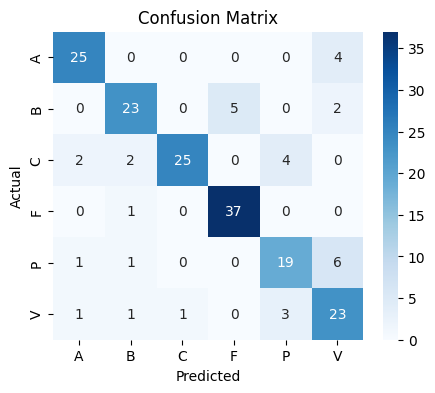

In [89]:
# Создание матрицы ошибок
conf_matrix = confusion_matrix(y_test, y_pred_pca)

# Визуализация с помощью heatmap из библиотеки seaborn
label_map = {'A': 0, 'B': 1, 'C': 2, 'F': 3, 'P': 4, 'V': 5}
class_names = list(label_map.keys())

plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [84]:
X_train.shape

(196, 10368)

In [83]:
X_train_pca.shape

(196, 48)

---

Пробуем разные ML модели

SVM Best Parameters: {'C': 0.1, 'gamma': 0.1, 'kernel': 'linear'}
SVM Accuracy: 0.8870967741935484


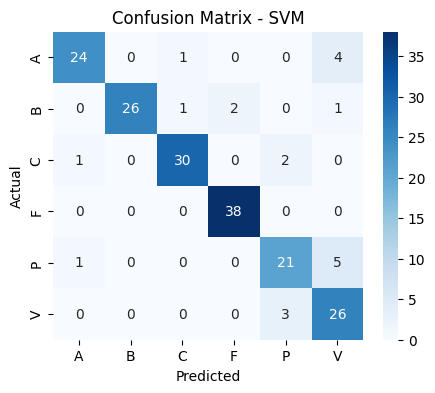

RandomForest Best Parameters: {'max_depth': 10, 'n_estimators': 200}
RandomForest Accuracy: 0.7849462365591398


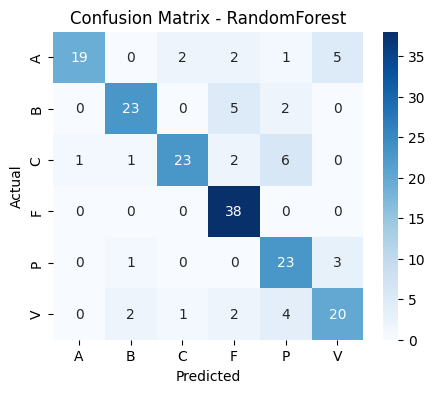

LogisticRegression Best Parameters: {'C': 0.1, 'solver': 'lbfgs'}
LogisticRegression Accuracy: 0.8924731182795699


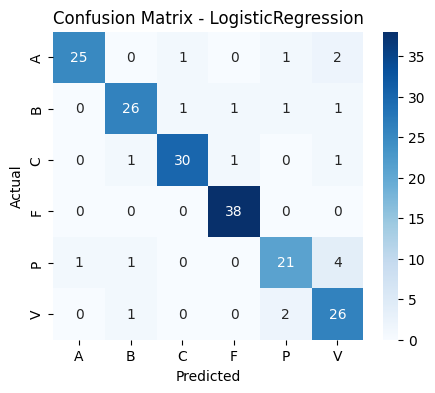

DecisionTree Best Parameters: {'max_depth': None, 'min_samples_split': 5}
DecisionTree Accuracy: 0.5


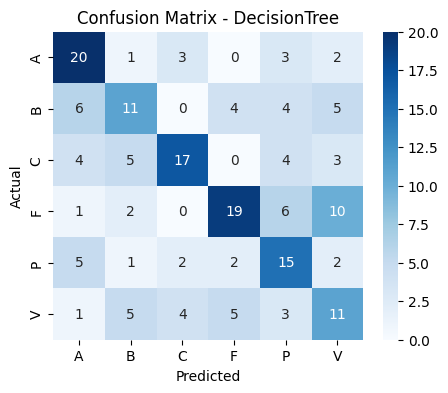

In [97]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Создание словаря моделей и их параметров для GridSearchCV
models = {
    'SVM': (SVC(), {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf'], 'gamma': [0.1, 0.01]}),
    'RandomForest': (RandomForestClassifier(), {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20]}),
    'LogisticRegression': (LogisticRegression(max_iter=1000), {'C': [0.1, 1, 10], 'solver': ['liblinear', 'lbfgs']}),
    'DecisionTree': (DecisionTreeClassifier(), {'max_depth': [None, 10, 20], 'min_samples_split': [2, 5, 10]})
}

# Перебор моделей с различными параметрами через GridSearchCV
for model_name, (model, parameters) in models.items():
    grid = GridSearchCV(model, parameters, cv=3)
    grid.fit(X_train_pca, y_train)

    # Получение выбранных лучших параметров модели
    best_params = grid.best_params_
    print(f"{model_name} Best Parameters: {best_params}")

    # Получение предсказаний на тестовых данных
    y_pred = grid.predict(X_test_pca)

    # Оценка точности модели
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{model_name} Accuracy: {accuracy}")

    # Создание и визуализация матрицы ошибок
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_names = list(label_map.keys())

    plt.figure(figsize=(5, 4))
    sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()
